In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from heapq import nsmallest
from scipy.signal import butter, lfilter, freqz
from scipy.fftpack import fft, ifft
from scipy import integrate
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import CubicSpline , interp1d

In [4]:
#Lecture data: lines klaus, cromospheric spectrum, VALD
#c_lines_spectrum =  pd.read_csv("absortionlines.csv", delimiter = ',', header = 0)
#clines = pd.read_csv("c_lines_spectrum.txt", delimiter = '\t', header = 0)
theoric_lines = pd.read_csv('DataSet/Inputs/theoric_c_lines.txt', delimiter = '\t', header = 0)
#theoric_lines =  pd.read_excel("lines.xlsx",sheet_name="cromospheric_lines", columns = ['waveobs','wave_base', 'wave_top','element'] )
theoric_lines['wave_peak'] = theoric_lines['wave_peak']/10
theoric_lines['wave_base'] = theoric_lines['wave_base']/10
theoric_lines['wave_top'] = theoric_lines['wave_top']/10
c_s = pd.read_csv('DataSet/Inputs/Subtracted_spectrum_F1-9.txt', delimiter = '\t', header = 0)

data_klaus = pd.read_csv("DataSet/Inputs/Fe1_data_klaus.txt", delimiter = '\t', usecols = ['lambda', 'loggf', 'ewr1'], header = 0)

growth_c_ispec_gauss = pd.read_csv("DataSet/Outputs/Fe1_subtracted_ispec_gauss.dat", delimiter = '\t', usecols = ['wave_nm', 'wave_base', 'wave_top','loggf', 'ewr'], header = 0)
growth_c_ispec_voigth = pd.read_csv("DataSet/Outputs/Fe1_subtracted_ispec_voigt.dat", delimiter = '\t', usecols = ['wave_nm', 'wave_base', 'wave_top','loggf', 'ewr'], header = 0)

growth_c_mine = pd.read_csv("DataSet/Outputs/Fe 1_growth_curve_substract.dat", delimiter = '\t', usecols = ['wave_peak', 'wave_base', 'wave_top','loggf', 'EWR'], header = 0)
Atomic_lines = pd.read_csv('DataSet/Inputs/atomic_lines.tsv', delimiter = '\t', usecols = ['element', 'wave_A','loggf'], header = 0, low_memory=False, keep_default_na= False)

In [14]:
c_s

,waveobs,flux,err
0,375.010,0.710204,0.043839
1,375.011,0.736027,0.044753
2,375.012,0.761851,0.045666
3,375.013,0.716938,0.044197
4,375.014,0.670040,0.042653
...,...,...,...
194975,569.985,0.775035,0.018635
194976,569.986,0.764939,0.018558
194977,569.987,0.754843,0.018482
194978,569.988,1.699439,0.014429


## Found absortion lines

In [77]:
top = []
for i in range(len(theoric_lines['wave_top'])):
    top.append(nsmallest(1,c_s['waveobs'], key = lambda x: abs(x-theoric_lines['wave_top'][i]))[0])

In [78]:
base = []
for i in range(len(theoric_lines['wave_base'])):
    base.append(nsmallest(1,c_s['waveobs'], key = lambda x: abs(x-theoric_lines['wave_base'][i]))[0])

In [81]:
#Create new list with contain the absortion lines in cromospheric spectrum with its respective element
c_lines_spectrum = pd.DataFrame(columns = ['wave_peak', 'wave_base', 'wave_top','note', 'flux', 'error_f'])
L = []
I = []
mins = []
       
for i in range(len(base)):
    b = c_s['waveobs']>base[i]
    a = c_s['waveobs']<top[i]
    c = a&b 
    min_ = min(c_s['flux'][c])
    L.append(c_s["waveobs"][c][c_s["flux"][c] == min_].tolist()[0])
    I.append(c_s['flux'][c][c_s["flux"][c] == min_].tolist()[0])
    mins.append(min_)
    
c_lines_spectrum['wave_peak'] = L
c_lines_spectrum['wave_base'] = base
c_lines_spectrum['wave_top'] = top
c_lines_spectrum['note'] = theoric_lines['note']
c_lines_spectrum['flux'] = I
c_lines_spectrum['error_f'] = c_s['err']

In [83]:
c_lines_spectrum.to_csv("c_lines_spectrum.txt", sep='\t', index = False, header=True)

In [82]:
c_lines_spectrum

,wave_peak,wave_base,wave_top,note,flux,error_f
0,376.141,376.075,376.210,Ti 2,-0.031778,0.043839
1,376.385,376.340,376.434,Fe 1,0.111095,0.044753
2,376.726,376.670,376.755,Fe 1,0.178483,0.045666
3,376.942,376.941,376.951,Ni 2,0.414191,0.044197
4,377.067,377.058,377.068,H 1,-0.018008,0.042653
...,...,...,...,...,...,...
101,456.378,456.348,456.432,Ti 2,0.189061,0.048734
102,457.202,457.147,457.248,Ti 2,0.161474,0.050448
103,458.391,458.303,458.444,Fe 2,0.229323,0.052161
104,458.996,458.962,459.028,Ti 2,0.521219,0.053875


In [35]:
data_element = c_lines_spectrum[c_lines_spectrum['element'] == 'Ti 2']
data_element.index = list(range(len(data_element)))
data_element

,waveobs,wave_base,wave_top,element,flux,error_f
0,376.141,376.075,376.210,Ti 2,-0.031778,0.043839
1,378.801,378.758,378.821,Ti 2,0.487668,0.038036
2,382.041,381.998,382.102,Ti 2,0.062097,0.031372
3,382.455,382.405,382.491,Ti 2,0.325723,0.030359
4,391.357,391.302,391.398,Ti 2,0.088786,0.037501
5,393.370,393.361,393.371,Ti 2,0.023726,0.042899
6,394.525,394.516,394.526,Ti 2,1.241088,0.046374
7,399.902,399.893,399.903,Ti 2,0.977744,0.049144
8,417.757,417.749,417.759,Ti 2,0.647348,0.047001
9,422.677,422.668,422.678,Ti 2,0.019586,0.051112


In [39]:
#Separate by elements
Fe1__ = theoric_lines[theoric_lines['element']=='Fe 1']
Ti2__ = theoric_lines[theoric_lines['element']=='Ti 2']
Fe2__ = theoric_lines[theoric_lines['element']=='Fe 2']

Fe1__.index = list(range(len(Fe1__)))
Ti2__.index = list(range(len(Ti2__)))
Fe2__.index = list(range(len(Fe2__)))

Ti2__

,waveobs,wave_base,wave_top,element
0,376.132,376.075,376.210,Ti 2
1,378.788,378.758,378.821,Ti 2
2,382.043,381.998,382.102,Ti 2
3,382.445,382.405,382.491,Ti 2
4,391.346,391.302,391.398,Ti 2
5,393.366,393.361,393.371,Ti 2
6,394.521,394.516,394.526,Ti 2
7,399.898,399.893,399.903,Ti 2
8,417.754,417.749,417.759,Ti 2
9,422.673,422.668,422.678,Ti 2


## Associate atomic data

In [41]:
_Fe1 = lines_s[lines_s['element']=='Fe 1']
_Ti2 = lines_s[lines_s['element']=='Ti 2']
_Fe2 = lines_s[lines_s['element']=='Fe 2']

_Fe1.index = list(range(len(_Fe1)))
_Ti2.index = list(range(len(_Ti2)))
_Fe2.index = list(range(len(_Fe2)))

In [42]:
#Separate by elements the atomic lines for decrease the amount of data
Fe1_ = Atomic_lines[Atomic_lines['element']=='Fe 1']
Fe2_ = Atomic_lines[Atomic_lines['element']=='Fe 2']
Ti2_ = Atomic_lines[Atomic_lines['element']=='Ti 2']

#Use just workin data range
Fe1_VALD = Fe1_[(Fe1_['wave_A'] >= 3760) & (Fe1_['wave_A'] <= 4420)]
Fe1_VALD.index = list(range(len(Fe1_VALD)))
Fe2_VALD = Fe2_[(Fe2_['wave_A'] >= 3760) & (Fe2_['wave_A'] <= 4590)]
Fe2_VALD.index = list(range(len(Fe2_VALD)))
Ti2_VALD = Ti2_[(Ti2_['wave_A'] >= 3760) & (Ti2_['wave_A'] <= 4590)]
Ti2_VALD.index = list(range(len(Ti2_VALD)))

#Working in nm
Fe1_VALD['wave_A'] = Fe1_VALD['wave_A']/10
Fe2_VALD['wave_A'] = Fe2_VALD['wave_A']/10
Ti2_VALD['wave_A'] = Ti2_VALD['wave_A']/10


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [46]:
Ti2_VALD[93:110]

,element,wave_A,loggf
93,Ti 2,393.1680,-5.761
94,Ti 2,393.2009,-1.590
95,Ti 2,393.2161,-5.290
96,Ti 2,393.3763,-4.720
97,Ti 2,393.3990,-6.264
98,Ti 2,393.4384,-3.044
99,Ti 2,393.5594,-5.141
100,Ti 2,393.6306,-6.612
101,Ti 2,393.7812,-1.010
102,Ti 2,393.8141,-1.200


In [36]:
new_listgf = []
loggf = []
for i in range(len(Ti2['waveobs'])):
    x = abs(nsmallest(1,Ti2_VALD['wave_A'], key = lambda x: abs(x-Ti2['waveobs'][i]))[0] - Ti2['waveobs'][i])
    if x < 0.05:
        new_listgf.append(nsmallest(1,Ti2_VALD['wave_A'], key = lambda x: abs(x-Ti2['waveobs'][i]))[0])
        print(len(new_listgf))
        loggf.append(Ti2_VALD[Ti2_VALD["wave_A"] == new_listgf[i]]["loggf"].tolist()[0])

NameError: name 'Ti2' is not defined

# Base and top

In [105]:
Ti2_gf = pd.DataFrame(columns = ['waveobs','element', 'flux', 'loggf', 'wave_base', 'wave_top', 'error_f'])
Ti2_gf['waveobs'] = Ti2['waveobs']
Ti2_gf['element'] = Ti2['element']
Ti2_gf['flux'] = Ti2['flux']
Ti2_gf['loggf'] = loggf
Ti2_gf['wave_base'] = Ti2['wave_base']
Ti2_gf['wave_top'] = Ti2['wave_top']
Ti2_gf['error_f'] = c_s['err']

In [106]:
Ti2_gf

,waveobs,element,flux,loggf,wave_base,wave_top,error_f
0,376.141,Ti 2,-0.031778,0.180,376.075,376.210,0.043839
1,381.467,Ti 2,0.329533,-1.680,381.418,381.510,0.044753
2,388.239,Ti 2,0.860449,-1.870,388.210,388.264,0.045666
3,391.357,Ti 2,0.088786,-0.360,391.302,391.398,0.044197
4,401.247,Ti 2,0.296996,-1.780,401.206,401.285,0.042653
5,402.846,Ti 2,0.831117,-0.920,402.809,402.876,0.041112
6,429.417,Ti 2,0.143301,-0.930,429.348,429.452,0.039573
7,430.009,Ti 2,0.171436,-0.460,429.975,430.081,0.038036
8,375.909,Ti 2,-0.098185,-1.080,375.010,430.843,0.036502
9,431.290,Ti 2,0.374227,-1.120,431.261,431.329,0.035424


## Equivalent Width

#### Fit

In [107]:
#Number of splines
def step_continuum(Lmin,Lmax,splines):
    return (Lmax-Lmin)/splines

#New dots to found continuous
def Points_continuum(_lambda, Intensity,start,end,step):
    
    steps_list = np.arange(start,end, step)
    grouped_data = {}
    grouped_data['L'] = []
    grouped_data['I'] = []
    for i in range(1,len(steps_list)):
        grouped_lambda = _lambda[(_lambda >= steps_list[i-1]) & (_lambda < steps_list[i])]

        grouped_data['L'].append(grouped_lambda)
        grouped_data['I'].append(Intensity[  grouped_lambda.index  ])
    return grouped_data

#Fit contunuous to line data
def fit_continuum(grouped_data, L_min, L_max):  
    newdataL = [] 
    newdataI = []
    for i in range(len(grouped_data['I'])):
        newdataL.append(grouped_data['L'][i].median())
        newdataI.append(grouped_data['I'][i].median())
        data_fitL = [x for x in newdataL if str(x) != 'nan']
        data_fitI = [x for x in newdataI if str(x) != 'nan']
    cs = InterpolatedUnivariateSpline(data_fitL,data_fitI)
    xs =  np.linspace(L_min,  L_max, 100)
    fit =  pd.DataFrame({'L': xs, 'I': cs(xs)})
    return fit

In [135]:
step = step_continuum(Ti2_gf['wave_base'][0],Ti2_gf['wave_top'][0],20)

grouped_data = Points_continuum(c_s['waveobs'], c_s['flux'],Ti2_gf['wave_base'][0],Ti2_gf['wave_top'][0],step)

fit1 = fit_continuum(grouped_data, Ti2_gf['wave_base'][0], Ti2_gf['wave_top'][0]+0.07)
fit = fit1[(fit1['L'] >= Ti2_gf['wave_base'][0]) & (fit1['L'] <= Ti2_gf['wave_top'][0])]
fit

,L,I
0,376.075000,1.273505
1,376.077071,1.229357
2,376.079141,1.176255
3,376.081212,1.115694
4,376.083283,1.049175
...,...,...
61,376.201313,0.951128
62,376.203384,0.875268
63,376.205455,0.754169
64,376.207525,0.582042


#### Pseudocontinuou

In [120]:
def pseudocontinuou(Data,LMIN, LMAX):
    pseudo_continuous1 = c_s[(c_s['waveobs'] <= LMIN)  & (c_s['waveobs'] > (LMIN-0.05))]
    pseudo_continuous2 = c_s[(c_s['waveobs'] >= LMAX )  & (c_s['waveobs'] < (LMAX+0.05))]
    pseudo_continuous1.index = list(range(len(pseudo_continuous1)))
    pseudo_continuous2.index = list(range(len(pseudo_continuous2)))

    mean1 = np.mean(pseudo_continuous1)
    mean2 = np.mean(pseudo_continuous2)
    mean = (mean1['flux'] + mean2['flux'])/2
    return mean

In [121]:
mean = pseudocontinuou(c_s, Ti2_gf['wave_base'][0], Ti2_gf['wave_top'][0])

In [147]:
b = c_s['waveobs']>lines_s['wave_base'][0]
a = c_s['waveobs']<lines_s['wave_top'][0]
c = a&b
L = []
I = []
L.append(c_s["waveobs"][c][c_s["waveobs"][c] == c].tolist()[0])
I.append(c_s['flux'][c][c_s["waveobs"][c] == c].tolist()[0])

ValueError: Can only compare identically-labeled Series objects

In [171]:
def loggf(element, data_element, atomic_data_element,spectrum, theoric_abs_lines):
    element_ = theoric_abs_lines[theoric_abs_lines['element']== element]
    element_.index = list(range(len(element_)))

    new_listgf = []
    loggf = []
    for i in range(len(element_['waveobs'])):
        x = abs(nsmallest(1,atomic_data_element['wave_A'], key = lambda x: abs(x-element_['waveobs'][i]))[0] - element_['waveobs'][i])
        if x < 0.02:
            new_listgf.append(nsmallest(1,atomic_data_element['wave_A'], key = lambda x: abs(x-element_['waveobs'][i]))[0])
            loggf.append(atomic_data_element[atomic_data_element["wave_A"] == new_listgf[i]]["loggf"].tolist()[0])
    return new_listgf

In [172]:
loggf('Ti 2', _Ti2, Ti2_VALD,c_s, lines_)

[376.1321,
 381.45799999999997,
 388.2287,
 391.3461,
 401.2384,
 402.8338,
 429.4094,
 430.0042,
 430.7866,
 431.28599999999994,
 434.4281,
 439.5031,
 439.97650000000004,
 441.77139999999997,
 444.38009999999997,
 446.84929999999997,
 450.12700000000007,
 453.396,
 454.96220000000005,
 456.37570000000005,
 457.1971,
 458.9958]

In [168]:
def list_loggf(element, data_element, atomic_data_element,spectrum, theoric_abs_lines):
    element_ = theoric_abs_lines[theoric_abs_lines['element']== element]
    element_.index = list(range(len(element_)))

    new_listgf = []
    loggf = []
    for i in range(len(element_['waveobs'])):
        x = abs(nsmallest(1,atomic_data_element['wave_A'], key = lambda x: abs(x-element_['waveobs'][i]))[0] - element_['waveobs'][i])
        if x < 0.02:
            new_listgf.append(nsmallest(1,atomic_data_element['wave_A'], key = lambda x: abs(x-element_['waveobs'][i]))[0])
            loggf.append(atomic_data_element[atomic_data_element["wave_A"] == new_listgf[i]]["loggf"].tolist()[0])
    print(len(new_listgf))
    Ti2_gf = pd.DataFrame(columns = ['waveobs','element', 'flux', 'loggf', 'wave_base', 'wave_top', 'error_f'])
    Ti2_gf['waveobs'] = data_element['waveobs']
    Ti2_gf['element'] = data_element['element']
    Ti2_gf['flux'] = data_element['flux']
    Ti2_gf['loggf'] = loggf
    Ti2_gf['wave_base'] = data_element['wave_base']
    Ti2_gf['wave_top'] = data_element['wave_top']
    Ti2_gf['error_f'] = spectrum['err']
    return Ti2_gf

In [169]:
list_loggf('Ti 2', _Ti2, Ti2_VALD,c_s, lines_)

[376.1321, 381.45799999999997, 388.2287, 391.3461, 401.2384, 402.8338, 429.4094, 430.0042, 430.7866, 431.28599999999994, 434.4281, 439.5031, 439.97650000000004, 441.77139999999997, 444.38009999999997, 446.84929999999997, 450.12700000000007, 453.396, 454.96220000000005, 456.37570000000005, 457.1971, 458.9958]


,waveobs,element,flux,loggf,wave_base,wave_top,error_f
0,376.141,Ti 2,-0.031778,0.180,376.075,376.210,0.043839
1,381.467,Ti 2,0.329533,-1.680,381.418,381.510,0.044753
2,388.239,Ti 2,0.860449,-1.870,388.210,388.264,0.045666
3,391.357,Ti 2,0.088786,-0.360,391.302,391.398,0.044197
4,401.247,Ti 2,0.296996,-1.780,401.206,401.285,0.042653
5,402.846,Ti 2,0.831117,-0.920,402.809,402.876,0.041112
6,429.417,Ti 2,0.143301,-0.930,429.348,429.452,0.039573
7,430.009,Ti 2,0.171436,-0.460,429.975,430.081,0.038036
8,375.909,Ti 2,-0.098185,-1.080,375.010,430.843,0.036502
9,431.290,Ti 2,0.374227,-1.120,431.261,431.329,0.035424


In [138]:
Area_rec = mean*(fit['L'][len(fit)-1] - fit['L'][0] )
Area_fit = integrate.simps(fit['I'], fit['L'])
Area_real = Area_rec - Area_fit
EW = Area_real/mean
Ti2_gf['wave_base'][0]
EW
#np.log(EW/Ti2_gf['wave_base'][0])

0.09197394568777621

In [ ]:
Ti2_growth_c = pd.DataFrame(columns = ['waveobs','element', 'flux', 'loggf', 'EW','wave_base', 'wave_top', 'error_f'])
    Ti2_growth_c['waveobs'] = element_gf['waveobs']
    Ti2_growth_c['element'] = element_gf['element']
    Ti2_growth_c['flux'] = element_gf['flux']
    Ti2_growth_c['loggf'] = element_gf['loggf']
    Ti2_growth_c['EW'] = EW
    Ti2_growth_c['wave_base'] = element_gf['wave_base']
    Ti2_growth_c['wave_top'] = element_gf['wave_top']
    Ti2_growth_c['error_f'] = element_gf['error_f']

## Graph

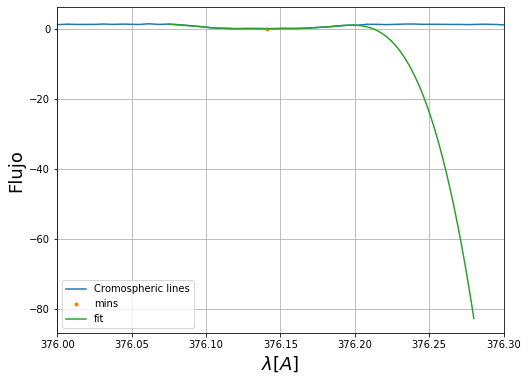

In [136]:
plt.figure(figsize = [8,6])
plt.plot(c_s['waveobs'],c_s['flux'],marker='', ls='-', label = 'Cromospheric lines')
plt.plot(lines_s['waveobs'],lines_s['flux'],marker='.', ls='', label = 'mins')
plt.plot(fit1['L'],fit1['I'],marker='', ls='-', label = 'fit')

plt.xlim(376,376.3)
#plt.ylim(-2.5, 3)
plt.grid()
plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()


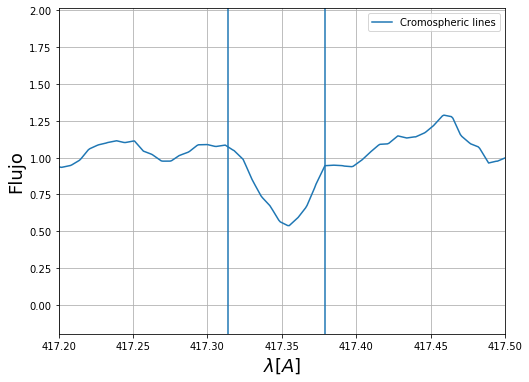

In [74]:
plt.figure(figsize = [8,6])
plt.plot(c_s['waveobs'],c_s['flux'],marker='', ls='-', label = 'Cromospheric lines')
#plt.plot(432.075,0.3,marker='.', ls='', label = 'mins')
plt.xlim(417.2,417.5)
plt.axvline(417.314)
plt.axvline(417.379)
#plt.ylim(-2.5, 3)
plt.grid()
plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [15]:
data_klaus

,lambda,loggf,ewr1
0,3685.19,0.20,-3.71
1,3076.22,-0.60,-4.38
2,3741.63,-0.14,-4.17
3,3757.68,-0.49,-4.37
4,3759.29,0.22,-3.70
5,3761.32,0.12,-3.72
6,3776.06,-1.37,-5.07
7,3786.33,-2.00,-4.95
8,3813.39,-1.99,-4.54
9,3814.58,-1.69,-4.34


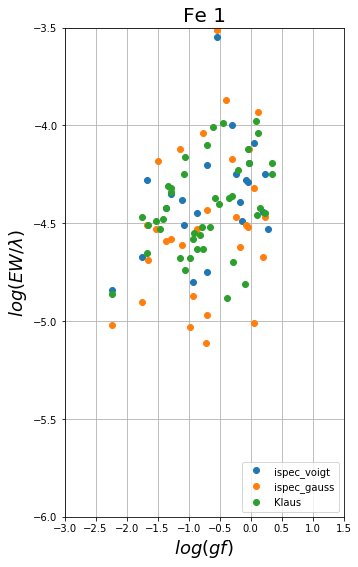

In [7]:
plt.figure(figsize = [5,9])
plt.plot(growth_c_ispec_voigth['loggf'],growth_c_ispec_voigth['ewr'],marker='o', ls='', label = 'ispec_voigt')
plt.plot(growth_c_ispec_gauss['loggf'],growth_c_ispec_gauss['ewr'],marker='o', ls='', label = 'ispec_gauss')
#plt.plot(growth_c_mine['loggf'],growth_c_mine['EWR'],marker='o', ls='', label = 'Lucía')
plt.plot(data_klaus['loggf'],data_klaus['ewr1'],marker='o', ls='', label = 'Klaus')

#plt.plot(fit1['L'],fit1['I'],marker='', ls='-', label = 'fit')
    
plt.xlim(-3,1.5)
plt.ylim(-6, -3.5)
plt.grid()
plt.legend(loc="lower right")
plt.title('Fe 1',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()